This notebook will train an XGBoost regression model to predict dam fullness
you may not need to run this if you already have the model from the repo


In [1]:
# pip install bayesian-optimization

In [2]:
from datetime import datetime
import pickle
import json
import glob
import os

from sklearn.metrics import (
    mean_absolute_error,
    mean_tweedie_deviance,
    mean_absolute_percentage_error,
)
from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization
import xgboost
import seaborn as sns

sns.set_theme(color_codes=True)
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import scipy.stats
import matplotlib.pyplot as plt

In [3]:
# path to training and validation data
training_data_path = os.path.join(os.getcwd(), "data/dam forecast train.csv")

val_data_path = os.path.join(os.getcwd(), "data/dam forecast val.csv")

In [4]:
# set location to save model
model_folder = os.getcwd()
model_name = "dam_forecast_15-10-24.pkl"
model_path = os.path.join(model_folder, "data", model_name)
model_path

'/home/nick/Documents/Work code/Weather-to-water/data/dam_forecast_15-10-24.pkl'

In [5]:
# we limit the max dam size as large dams are note well represented in our dataset
max_value = 20000

In [6]:
# load up training data, do some cleaning/sorting
training_data = pd.read_csv(training_data_path)
training_data = training_data.reindex(sorted(training_data.columns), axis=1)
training_data = training_data[training_data["dam_area"] < max_value]
training_data.replace([np.inf, -np.inf], 0, inplace=True)
training_data.head()

,SRC_DATE,acq_date_dec,acq_month,acq_year,class,class_name,dam_area,file_name,geometry,rain_0_months before,...,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before,water_area
0,20191216,2019.923077,12,2019,2,no water,1499.986376,arcgisonline_13466_pred_and_score.tif,POINT (150.7703260923624 -34.49997476956882),2.762451,...,20.396746,17.926054,15.415278,12.961130,13.086934,13.189901,16.016296,18.968658,21.853695,0.000000
1,20191216,2019.923077,12,2019,2,no water,1957.925202,arcgisonline_19956_pred_and_score.tif,POINT (150.7609417292462 -34.5194085769909),3.197464,...,20.336300,17.855085,15.332343,12.882524,13.011043,13.112334,15.936459,18.891691,21.774044,0.000000
2,20191216,2019.923077,12,2019,2,no water,56.557682,arcgisonline_29686_pred_and_score.tif,POINT (150.7921407085229 -34.48640159069117),2.658848,...,20.390297,17.952702,15.478308,13.054444,13.186954,13.291353,16.112299,19.028639,21.890549,0.000000
3,20191216,2019.923077,12,2019,0,dam and water,620.839041,arcgisonline_2208_pred_and_score.tif,POINT (150.8273026231211 -34.59007854166663),4.103868,...,19.747135,17.428568,15.065031,12.862777,13.064048,13.170877,15.932156,18.648500,21.329342,69.919793
4,20191216,2019.923077,12,2019,0,dam and water,911.591665,arcgisonline_43254_pred_and_score.tif,POINT (150.8025877887565 -34.57963568981891),3.889048,...,20.026794,17.639698,15.219195,12.937696,13.106893,13.211027,16.005402,18.805094,21.575476,85.853539


In [7]:
# load up validation data and do some cleaning/sorting
val_data = pd.read_csv(val_data_path)
val_data = val_data.reindex(sorted(val_data.columns), axis=1)
val_data = val_data[val_data["dam_area"] < max_value]
val_data.replace([np.inf, -np.inf], 0, inplace=True)
val_data.head()

,SRC_DATE,acq_date_dec,acq_month,acq_year,class,class_name,dam_area,file_name,geometry,rain_0_months before,...,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before,water_area
0,20151012,2015.769231,10,2015,0,dam and water,1467.191148,arcgisonline_132898_pred_and_score.tif,POINT (117.3172965191077 -33.24564247144878),9.043823,...,12.835136,11.108263,10.531229,12.044368,12.067635,16.236391,20.395378,24.588543,23.805340,400.256079
1,20160808,2016.615385,8,2016,0,dam and water,7575.018970,arcgisonline_70618_pred_and_score.tif,POINT (152.9625759629707 -26.43549796464562),30.879414,...,16.208225,16.421938,19.850100,22.161938,24.166159,25.166771,24.075779,23.361519,23.210749,5781.220903
2,20150329,2015.230769,3,2015,0,dam and water,2028.126533,arcgisonline_84979_pred_and_score.tif,POINT (142.9804044837108 -37.77391478774938),22.954985,...,20.310444,18.668152,16.997301,15.661266,13.949310,11.053338,8.662997,8.203583,9.625609,581.212166
3,20151215,2015.923077,12,2015,0,dam and water,569.161178,arcgisonline_101081_pred_and_score.tif,POINT (145.618767566165 -38.4325091507143),37.716213,...,15.805417,15.925524,11.613432,9.590775,9.022965,10.216203,12.452333,14.021166,16.439243,317.463008
4,20160416,2016.307692,4,2016,0,dam and water,3367.296500,arcgisonline_125002_pred_and_score.tif,POINT (118.0078021793126 -30.57147183423009),31.052204,...,24.274788,26.393480,26.532434,24.433882,23.749607,21.477095,14.928035,12.299461,11.371953,508.559500


In [8]:
training_data.shape

(108847, 36)

In [9]:
val_data.shape

(12092, 36)

In [10]:
# set a list of columns to drop, the model will not see these
drop_list = [
    "water_area",
    "file_name",
    "SRC_DATE",
    "geometry",
    "acq_year",
    "acq_month",
    "acq_date_dec",
    "class",
    "class_name",
]

In [11]:
# remove the drop list and setup target df
train_X = training_data.drop(columns=drop_list)
train_y = training_data[["water_area"]]
print(train_y.head())
train_X.head()

   water_area
0    0.000000
1    0.000000
2    0.000000
3   69.919793
4   85.853539


,dam_area,rain_0_months before,rain_10_months before,rain_11_months before,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,...,tavg_12_months before,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before
0,1499.986376,2.762451,36.125671,71.728584,69.268257,18.543798,32.006516,61.439262,35.894455,16.539648,...,22.234226,20.396746,17.926054,15.415278,12.961130,13.086934,13.189901,16.016296,18.968658,21.853695
1,1957.925202,3.197464,38.361225,75.389587,73.195740,19.394297,34.531719,64.828262,38.369305,17.053242,...,22.165726,20.336300,17.855085,15.332343,12.882524,13.011043,13.112334,15.936459,18.891691,21.774044
2,56.557682,2.658848,35.916077,69.969917,66.735779,18.249218,31.475410,60.696507,35.672646,16.840359,...,22.226084,20.390297,17.952702,15.478308,13.054444,13.186954,13.291353,16.112299,19.028639,21.890549
3,620.839041,4.103868,46.451984,76.181908,72.046654,19.497202,38.455097,70.509048,42.860733,19.531702,...,21.477997,19.747135,17.428568,15.065031,12.862777,13.064048,13.170877,15.932156,18.648500,21.329342
4,911.591665,3.889048,44.183247,76.219666,72.164078,19.490854,37.583042,69.094116,42.032280,18.774553,...,21.803089,20.026794,17.639698,15.219195,12.937696,13.106893,13.211027,16.005402,18.805094,21.575476


In [12]:
# setup validation sets
val_X = val_data.drop(columns=drop_list)
val_y = val_data[["water_area"]].copy()
print(train_y.head())
print(train_X.shape)
train_X.head()

   water_area
0    0.000000
1    0.000000
2    0.000000
3   69.919793
4   85.853539
(108847, 27)


,dam_area,rain_0_months before,rain_10_months before,rain_11_months before,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,...,tavg_12_months before,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before
0,1499.986376,2.762451,36.125671,71.728584,69.268257,18.543798,32.006516,61.439262,35.894455,16.539648,...,22.234226,20.396746,17.926054,15.415278,12.961130,13.086934,13.189901,16.016296,18.968658,21.853695
1,1957.925202,3.197464,38.361225,75.389587,73.195740,19.394297,34.531719,64.828262,38.369305,17.053242,...,22.165726,20.336300,17.855085,15.332343,12.882524,13.011043,13.112334,15.936459,18.891691,21.774044
2,56.557682,2.658848,35.916077,69.969917,66.735779,18.249218,31.475410,60.696507,35.672646,16.840359,...,22.226084,20.390297,17.952702,15.478308,13.054444,13.186954,13.291353,16.112299,19.028639,21.890549
3,620.839041,4.103868,46.451984,76.181908,72.046654,19.497202,38.455097,70.509048,42.860733,19.531702,...,21.477997,19.747135,17.428568,15.065031,12.862777,13.064048,13.170877,15.932156,18.648500,21.329342
4,911.591665,3.889048,44.183247,76.219666,72.164078,19.490854,37.583042,69.094116,42.032280,18.774553,...,21.803089,20.026794,17.639698,15.219195,12.937696,13.106893,13.211027,16.005402,18.805094,21.575476


In [13]:
# save out metadata to json, this is usefull when running predictions
meta_dict = {
    "col_names": list(train_X.columns),
    "model_path": model_path,
    "creation_date": str(datetime.today().strftime("%Y-%m-%d")),
}

with open(model_path.replace(".pkl", ".json"), "w") as fp:
    json.dump(meta_dict, fp)

In [14]:
train_X.sample(frac=0.8)

,dam_area,rain_0_months before,rain_10_months before,rain_11_months before,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,...,tavg_12_months before,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before
61734,1419.725928,8.204866,2.403445,30.758289,24.182323,11.832789,6.037231,33.253567,54.439816,75.453476,...,18.272152,18.117992,17.322460,12.857838,11.242927,10.505464,11.856104,13.519507,14.636414,18.001894
31502,1660.873499,134.093719,56.295082,39.512234,44.345024,43.472206,19.045341,22.624388,9.922977,109.187737,...,9.688309,13.396880,18.586721,21.845974,22.871428,21.813419,21.344553,20.946459,18.317787,11.926553
6358,1193.739909,36.130630,35.261532,14.769051,39.706047,32.397419,34.521164,95.343330,116.798531,44.827366,...,19.846521,17.734188,13.668169,10.890540,9.896046,8.483364,7.828810,7.881200,11.553442,15.103018
73595,722.447814,24.673418,71.650284,26.947121,65.953941,18.784986,43.762020,62.476021,25.205826,46.687023,...,15.462850,16.524538,20.414146,19.143311,17.645271,16.397741,14.841598,12.571360,10.042193,9.655922
23555,3481.101729,27.219296,48.221375,79.172050,40.129555,152.614655,74.053192,85.791290,157.099060,61.559113,...,22.859848,13.088414,10.527823,10.478975,10.767557,14.474834,20.902191,25.244669,26.666601,26.442799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7699,1354.478469,48.701641,18.973745,22.754864,269.041565,60.180527,57.962856,44.143051,73.648933,38.881435,...,22.806923,24.139906,20.983032,17.090874,14.988796,12.027188,11.964249,12.517964,15.643492,19.273605
110094,1794.319820,48.794262,30.776892,56.829494,69.166664,60.999496,210.332275,74.534332,106.991020,95.457718,...,19.183870,20.507034,21.318043,18.104710,16.496952,13.312007,10.166120,8.165903,7.915401,8.351945
21224,972.336198,25.742090,5.885843,68.342552,10.440559,144.398987,73.365250,63.327457,132.888367,82.380142,...,20.132479,10.274904,9.540792,8.251196,9.312320,12.809038,17.308435,21.901478,22.705770,23.953152
16452,1152.160397,28.622145,145.578583,141.687607,91.975639,39.544281,49.311890,148.443222,43.495728,160.559036,...,17.021755,12.127263,10.472900,7.820857,7.934317,7.929717,11.680419,14.937031,17.545263,18.800554


In [15]:
model_path

'/home/nick/Documents/Work code/Weather-to-water/data/dam_forecast_15-10-24.pkl'

In [16]:
# func to train a model using variable inputs
def train_model(learning_rate, n_estimators, max_depth):
    n_estimators = round(n_estimators)
    max_depth = round(max_depth)

    xgb_reg = XGBRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        tree_method="hist",
        objective="reg:tweedie",
    )
    xgb_reg.fit(train_X, train_y, verbose=0)

    y_pred = xgb_reg.predict(val_X)
    y_pred = y_pred * (y_pred > 0)

    model_mean_error = mean_absolute_error(val_data["water_area"].to_numpy(), y_pred)

    return -model_mean_error

In [17]:
# set the bounds for optimization search
pbounds = {"learning_rate": (0.1, 0.5), "n_estimators": (10, 700), "max_depth": (1, 10)}

In [18]:
# setup optimizer
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

In [19]:
# run optimizer
optimizer.maximize(
    init_points=15,
    n_iter=30,
)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | -687.1    | 0.2668    | 7.483     | 10.08     |
| 2         | -366.0    | 0.2209    | 2.321     | 73.71     |
| 3         | -335.4    | 0.1745    | 4.11      | 283.8     |
| 4         | -341.3    | 0.3155    | 4.773     | 482.8     |
| 5         | -365.3    | 0.1818    | 8.903     | 28.9      |
| 6         | -337.6    | 0.3682    | 4.756     | 395.5     |
| 7         | -335.8    | 0.1562    | 2.783     | 562.5     |
| 8         | -342.2    | 0.4873    | 3.821     | 487.7     |
| 9         | -356.1    | 0.4506    | 9.051     | 68.68     |
| 10        | -337.7    | 0.1156    | 2.528     | 615.9     |
| 11        | -331.1    | 0.1393    | 4.79      | 670.9     |
| 12        | -344.7    | 0.3133    | 7.227     | 227.7     |
| 13        | -351.6    | 0.3746    | 8.512     | 22.62     |
| 14        | -423.4    | 0.4001    | 9.9       | 526.2     |
| 15    

In [20]:
# show best vars
# best_pers = optimizer.max
# best_pers

In [21]:
def train_fin_model(learning_rate, n_estimators, max_depth):
    n_estimators = round(n_estimators)
    max_depth = round(max_depth)
    xgb_reg = XGBRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        tree_method="hist",
        objective="reg:tweedie",
    )
    xgb_reg.fit(train_X, train_y, eval_set=[(train_X, train_y)], verbose=0)

    return xgb_reg

In [22]:
model_count = 10

In [23]:
top_models = (
    pd.DataFrame(optimizer.res)
    .sort_values("target", ascending=[False])
    .head(model_count)
)
top_models

,target,params
10,-331.147434,"{'learning_rate': 0.13933873353322004, 'max_de..."
16,-332.013330,"{'learning_rate': 0.158421467118762, 'max_dept..."
15,-335.082368,"{'learning_rate': 0.2794549135950227, 'max_dep..."
2,-335.437491,"{'learning_rate': 0.17450408455106836, 'max_de..."
20,-335.625920,"{'learning_rate': 0.1814859653763875, 'max_dep..."
6,-335.848548,"{'learning_rate': 0.15615477543809353, 'max_de..."
21,-335.856333,"{'learning_rate': 0.25107332479516714, 'max_de..."
5,-337.609413,"{'learning_rate': 0.36818700407136096, 'max_de..."
9,-337.666575,"{'learning_rate': 0.11562191329315295, 'max_de..."
19,-339.712219,"{'learning_rate': 0.35373861330117334, 'max_de..."


In [24]:
models = []
for row, model_hyps in tqdm(top_models.iterrows(), total=model_count):
    models.append(
        {"model_number": str(row), "model": train_fin_model(**model_hyps["params"])}
    )

  0%|          | 0/10 [00:00<?, ?it/s]

In [25]:
preds = pd.DataFrame()
for model in models:
    y_pred = model["model"].predict(val_X)
    y_pred = y_pred * (y_pred > 0)
    preds[model["model_number"]] = y_pred

In [26]:
preds

,10,16,15,2,20,6,21,5,9,19
0,265.429779,272.755127,264.661743,275.949097,274.209534,300.066559,250.666580,309.251007,302.197876,268.213440
1,3995.846436,4230.609863,4200.282227,4185.950195,4028.511475,4175.894531,4261.847656,3854.417480,4188.273926,3977.676270
2,453.383484,398.620361,439.124756,470.634064,517.024719,467.704041,413.752747,518.470215,538.903748,513.096130
3,226.201630,215.233337,243.331985,213.247498,223.076462,214.308563,224.037888,213.950989,221.146881,233.530762
4,944.884094,1091.634521,1025.997070,885.483459,970.188660,1003.173706,886.053223,1138.050659,950.609497,695.715271
...,...,...,...,...,...,...,...,...,...,...
12087,4162.300293,3934.830811,3953.570557,4321.417969,4247.970215,4104.645996,3984.362061,4066.094238,3903.550781,3754.659668
12088,227.459000,193.968430,190.941284,210.911377,211.090073,206.571579,207.157104,255.784515,208.095764,198.821899
12089,1306.092529,1576.290649,1193.225464,1324.671875,1060.043701,1331.555664,1275.681152,1517.010986,1408.103516,1226.500000
12090,1217.091675,1272.231323,1257.115112,1170.063843,1216.206421,1258.986084,1304.750488,1268.725586,1264.381348,1266.108154


In [27]:
val_y["preds"] = preds.mean(axis=1).to_list()

In [28]:
val_y

,water_area,preds
0,400.256079,278.340088
1,5781.220903,4109.930664
2,581.212166,473.071442
3,317.463008,222.806595
4,508.559500,959.179016
...,...,...
12230,5955.113008,4043.340332
12231,106.330725,211.080078
12232,2320.997848,1321.917480
12233,1341.055972,1249.566162


In [29]:
val_y.to_csv("data/dam forecast val vs pred.csv")

[(0.0, 20000.0)]

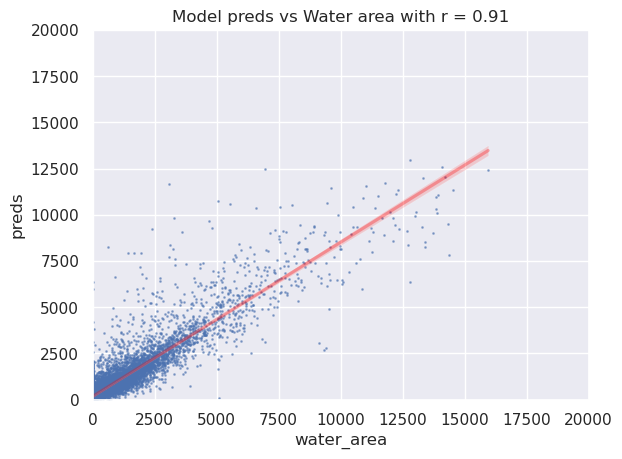

In [30]:
# plot up validation data preds vs measured values
ax = sns.regplot(
    x="water_area",
    y="preds",
    data=val_y,
    scatter_kws={"s": 1, "alpha": 0.5},
    line_kws={"color": "red", "alpha": 0.3},
)

# Calculate the correlation coefficient (r value)
r_value, p_value = scipy.stats.pearsonr(val_y["water_area"], val_y["preds"])
plt.title(f"Model preds vs Water area with r = {r_value:.2f}")

sns.set(rc={"figure.figsize": (8, 8)})
ax.set(ylim=(0, max_value))
ax.set(xlim=(0, max_value))

In [31]:
# use numpy to calc the line of best fit equation
# note this this looks much better than the scaled factor above
grad, y_intersect = np.polyfit(val_y["water_area"], val_y["preds"], 1)
grad, y_intersect

(0.8342766924591287, 164.77570924651081)

In [32]:
# significant improvement from scaled factor above
model_mae = mean_absolute_error(val_y["water_area"], val_y["preds"])
model_mae

328.7734850189659

In [33]:
# mean model error percent
model_mae / val_y["water_area"].mean()

0.3238297743708128

In [34]:
# mape = np.mean(np.abs(val_y['water_area'] - val_y['preds'])/val_y['preds'])*100
# mape

In [35]:
model_improvment = 1 - (model_mae / 466.89)
print(f"the model is {round(model_improvment*100)}% better than the scaled dam area")

the model is 30% better than the scaled dam area


In [36]:
model_improvment = 1 - (model_mae / 885.85)
print(
    f"the model is {round(model_improvment*100)}% better than always guessing water area mean"
)

the model is 63% better than always guessing water area mean


In [37]:
# save model to disk
# pickle.dump(xgb_reg, open(model_path, "wb"))
pickle.dump(models, open(model_path, "wb"))

In [38]:
model_path

'/home/nick/Documents/Work code/Weather-to-water/data/dam_forecast_15-10-24.pkl'